## Metropolis Sampler, From the 1953 Paper.




In [113]:
import jax.numpy as jnp
from jax import vmap, grad
import matplotlib.pyplot as plt
from jax.random import uniform, normal, PRNGKey, split

def dist(A, B):
    # Find closest periodic distance between A and B
    d1 = ((A[0]-B[0] + 0.5)%1) - 0.5
    d2 = ((A[1]-B[1] + 0.5)%1) - 0.5
    return (d1**2 + d2**2)**0.5

def find_closest(A, B):
    # Find closest version of particle (for visualization only)
    d1 = ((A[0]-B[0] + 0.5)%1) - 0.5
    d2 = ((A[1]-B[1] + 0.5)%1) - 0.5
    return B[0] + d1, B[1] + d2

def rejection_sampling(key, N, r, dmin=0):
    coord_list = []
    successes = 0
    while successes < N:
        key, skey = split(key, 2)
        coord = uniform(skey, (2,), minval=-0.5, maxval=0.5)
        dists = [dist(coord, c) for c in coord_list] + [3.]
        if min(dists)-2*r>dmin:
            coord_list.append(coord)
            successes += 1
        else:
            pass
    return jnp.array(coord_list)

def initialize():
    c1 = jnp.arange(14) * 1/14
    c2 = jnp.arange(16) * 1/16
    
    C1 = c1[None, :] + (jnp.arange(16)%2==1)[:, None] * 0.5 / 14 - 0.5
    C2 = c2[:, None] + jnp.zeros(14)[None, :] - 0.5
    return jnp.concatenate([C1.flatten()[:,None], C2.flatten()[:,None]], 1) #jnp.concatenate([C1[:,:,None], C2[:,:,None]], axis=2).reshape(-1, 2)[:10]
    

def plot_circle(coord, r, fillcolor=None, **kwargs):
    t = jnp.linspace(0,2*jnp.pi,100)
    cost = jnp.cos(t)
    sint = jnp.sin(t)
    plt.plot(cost*r + coord[0], sint*r + coord[1], **kwargs)
    if fillcolor is not None:
        plt.fill(cost*r + coord[0], sint*r + coord[1], color=[float(c) for c in fillcolor])

def plot_circles(coords, r, fillcolors, **kwargs):
    if fillcolors is None:
        fillcolors = jnp.ones((len(coords), 3))
    for c,fc in zip(coords, fillcolors):
        plot_circle(c, r, fillcolor=fc, **kwargs)
        
def plot_box(**kwargs):
    plt.plot([-0.5,0.5,0.5,-0.5,-0.5],[-0.5,-0.5,0.5,0.5,-0.5],**kwargs)
        
def plot_circle_distances(coords, r, **kwargs):
    for c1 in coords:
        for c2 in coords:
            c2c1 = find_closest(c2, c1)
            if max([abs(c) for c in c2c1]) > 0.5:
                plot_circle(c2c1, r, color="grey", **kwargs)
                plt.plot([c2c1[0], c1[0]], [c2c1[1], c1[1]], color="red", **kwargs)
    
def V(d, r):
    # Potential energy function
    return jnp.where(d>2*r, 0., jnp.inf)
    
def V_mat(Vfunc, coords):
    V_dists = vmap(lambda y: vmap(lambda x: Vfunc(dist(x,y)), 0)(coords), 0)(coords)
    return V_dists

def propose_move(key, step):
    # Propose a move for a particle
    #dx0 = normal(key, (2,)) * step
    dx0 = uniform(key, (2,), minval=-step, maxval=step) # Propose a step
    return dx0
    
def make_move(x, dx0, idx0):
    # Move particle idx0 by dx0
    x = x.at[idx0].set(((x[idx0] + dx0+0.5)%1) - 0.5)
    return x

def MH_step(key, x, dx0, idx0, dEval, kT):
    # Metropolis-Hastings step
    p = jnp.exp(-dEval/kT)
    u = uniform(key, (1,))
    return x if u > p else make_move(x, dx0, idx0)

def MH_step_vec(Vfunc, u, x, mask, x0, x1, r, kT):
    # Metropolis-Hastings step
    pot = lambda x, y: Vfunc(dist(x,y), r)
    E0 = jnp.where(mask, vmap(pot, (0, None))(x, x0), jnp.zeros(len(x))).sum()
    E1 = jnp.where(mask, vmap(pot, (0, None))(x, x1), jnp.zeros(len(x))).sum()
    p = jnp.exp(-(E1 - E0)/kT)
    return jnp.where(u > p, x0, x1)

def run_cycle_vec(key, Vfunc, x, r, step, kT):
    # Run a cycle of Metropolis-Hastings
    key, keyu, keys = split(key, 3)
    u = uniform(keyu, (len(x),))
    x1 = ((x + normal(keys, (len(x), 2)) * step + 0.5) % 1) - 0.5 # Propose a step
    mask = jnp.eye(len(x))
    
    mh_step = lambda u, m, x0, x1: MH_step_vec(Vfunc, u, x, m, x0, x1, r, kT)
    x = vmap(mh_step, (0, 0, 0, 0))(u, mask, x, x1)
    return x
    

def run_cycle(key, Vfunc, x, r, step, kT):
    for idx0 in range(len(x)):
        key, skey, skey2 = split(key, 3)
        dx0 = propose_move(skey, step)
        dE_val = dE(Vfunc, x, dx0, idx0, r)
        x = MH_step(skey2, x, dx0, idx0, dE_val, kT)
    return x

def run_cycles(key, Vfunc, x, r, step, kT, ncycles, nburn=0):
    # Run ncycles of Metropolis-Hastings
    xhist = []
    for i in range(ncycles+nburn):
        key, skey = split(key)
        x = run_cycle(skey, Vfunc, x, r, step, kT)
        print(f"Cycle {i+1}/{ncycles+nburn}.", end="\r")
        if i < nburn:
            pass
        else:
            xhist.append(x)
    return xhist

def dE(Vfunc, x, dx0, idx0, r):
    # Difference in energy before and after moving particle
    # dx0 is the change in position of particle idx0
    idx = jnp.arange(len(x))
    pot = lambda x, y: Vfunc(dist(x,y), r)
    E0 = vmap(pot, (0, None))(x[idx!=idx0], x[idx0]).sum()
    E1 = vmap(pot, (0, None))(x[idx!=idx0], x[idx0] + dx0).sum()
    return E1 - E0


def create_distance_histogram(xhist, dA2, d0, M, N):
    # For each cycle, compute pairwise distances and add to histogram bins
    mhist = []
    for n in range(N):
        z = xhist[n]
        pir2_vec = vmap(lambda x: vmap(lambda y: dist(x,y), 0)(z), 0)(z)
        pir2_vec = pir2_vec.flatten()**2 * jnp.pi
        m_vec = jnp.floor((pir2_vec - jnp.pi*d0**2)/dA2)
        m_vec = jnp.clip(m_vec, 0, M-1)
        m_vec = m_vec.astype(int)
        mhist.append(m_vec)
        
    mhist = jnp.concatenate(mhist)
    mhist = jnp.bincount(mhist, minlength=M)/N/2*len(xhist[0]) # Normalize by number of cycles and number of particles
    return mhist, jnp.arange(M)

In [114]:
# Parameters
N = 224 # Particles
M = 64 # Bins
kT = 1.
d = 1/14


PA_NkT_1_vec = []
AdivA0_1_vec = []
for nu in [2, 4, 5, 5.5, 6, 6.25, 6.5, 7]:
    K = 1.5

    # Variables
    r = d*(1-2**(nu-8))/2
    d0 = 2*r
    step = d - d0
    AdivA0 = 1/(0.98974329*(1-2**(nu-8))**2) #1/(3**0.5*d0**2*N/2)
    dA2 = (K**2 - 1)*jnp.pi*(d0**2)/M

    # MH parameters
    ncycles = 48
    nburn = 16

    x0 = initialize()
    xhist = run_cycles(PRNGKey(1), V, x0, r, step, kT, ncycles, nburn)

    
    Nm, m = create_distance_histogram(xhist, dA2, d0, M, ncycles)
    m_lin = m[1:17]-1
    Nm_lin = Nm[1:17]

    # Fit line to data
    X = jnp.vstack([m_lin, jnp.ones(len(m_lin))]).T
    Y = Nm_lin
    A = jnp.linalg.lstsq(X, Y, rcond=None)[0]
    slope, intercept = A[0], A[1]
    print(f"Slope: {slope}, Intercept: {intercept}")

    Nhalf = 0.5 * slope + intercept
    PA_NkT_1 = M*(Nhalf)/(N**2)/(K**2-1)#/N**2#/(K**2 - 1)*10 # scale byh 10??
    print(f"Nhalf: {Nhalf}, (PA/NkT)-1: {PA_NkT_1}")
    
    PA_NkT_1_vec.append(PA_NkT_1)
    AdivA0_1_vec.append(AdivA0-1)



Slope: -1878.944580078125, Intercept: 20720.79296875
Nhalf: 19781.3203125, (PA/NkT)-1: 20.185020446777344
Slope: -628.1949462890625, Intercept: 12475.921875
Nhalf: 12161.82421875, (PA/NkT)-1: 12.410024642944336
Slope: -194.96372985839844, Intercept: 6425.5205078125
Nhalf: 6328.03857421875, (PA/NkT)-1: 6.45718240737915
Slope: -110.57251739501953, Intercept: 4377.71142578125
Nhalf: 4322.42529296875, (PA/NkT)-1: 4.410637855529785
Slope: -57.06372833251953, Intercept: 2796.0205078125
Nhalf: 2767.488525390625, (PA/NkT)-1: 2.823967933654785
Slope: -38.55485153198242, Intercept: 2026.328369140625
Nhalf: 2007.0509033203125, (PA/NkT)-1: 2.048011302947998
Slope: -16.573486328125, Intercept: 1447.5931396484375
Nhalf: 1439.306396484375, (PA/NkT)-1: 1.4686800241470337
Slope: -2.7039170265197754, Intercept: 655.529541015625
Nhalf: 654.1776123046875, (PA/NkT)-1: 0.6675281524658203


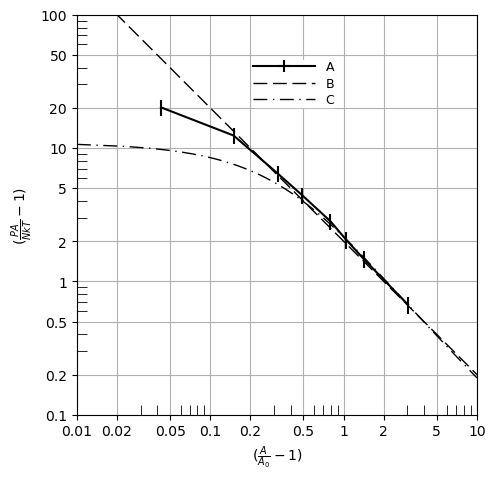

In [117]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
AdivA0_vec = jnp.array(AdivA0_1_vec) + 1
x = jnp.linspace(0.01, 10, 800)

plt.gca().errorbar(AdivA0_1_vec, PA_NkT_1_vec, xerr=0.0, yerr=jnp.array(PA_NkT_1_vec)/7, color="black", label="A")
#plt.plot(AdivA0_1_vec, PA_NkT_1_vec, "-+", color="black", label="A", markersize=13)

line1, = plt.plot(x, 2/((x+1)-1), color="black", linestyle="--", label="B", linewidth=1)
line1.set_dashes([10, 4])

line2, = plt.plot(x, 1.813799/(x+1) + 2.57269/(x+1)**2 + 3.179/(x+1)**3+3.38/(x+1)**4, color="black", linestyle="-.", label="C", linewidth=1)
line2.set_dashes([10, 4, 1, 4])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$(\\frac{A}{A_0}-1)$")
plt.ylabel("$(\\frac{PA}{NkT}-1)$")
yticks = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
xticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
plt.yticks(yticks, yticks)
plt.xticks(xticks, xticks)
plt.tick_params(axis="y", which="minor", direction="in", length=7)
plt.tick_params(axis="x", which="minor", direction="in", length=7)
plt.grid()
set_size(4, 4, ax=plt.gca())


handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
legend = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=[0.44,0.77], \
            fontsize=9, handlelength=5, borderpad=0, labelspacing=0.30, facecolor="white")#, facealpha=1.0)
plt.ylim([0.1, 100])
plt.xlim([0.01, 10])
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')
legend.get_frame().set_alpha(1.0)

plt.savefig("/home/emastr/github/multireference-alignment/notebooks/side_projects/figures/metropolis_figure_4_recreation.png", dpi=300, bbox_inches="tight")
None
